# Flowing Through Pixels: Building and Analyzing Unit Hydrograph

The unit hydrograph is a line graph that shows how much water flows in a river during a rainfall event. Therefore, the unit hydrograph plays a crucial role in hydrological studies. One example of its application is that, through the unit hydrograph, we can predict flood in a specific catchment by analyzing the rising limb time — the process from baseflow to peak flow — and observing how long the recession limb takes to return to baseflow.

One of the fundamental concepts of the unit hydrograph is that its shape is determined not only by storm characteristics (e.g., rainfall intensity and duration) but also by the physical characteristics of the catchment (e.g., catchment size, catchment shape, slope angle, soil type, vegetation type, land cover, and antecedent soil moisture), which are relatively static over time. Therefore, if a unit hydrograph can be derived from a catchment, it can be used to predict future storm events. In short, two identical rainfall events occurring in a catchment under the same antecedent conditions will produce the same hydrograph.

In [1]:
# Import standard python packages
import sys
import subprocess

# Ask GRASS where its Python packages are and add them to the path
grass_call = "grass84"
sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=True).strip()
)

# Import the GRASS python packages we need
import grass.script as gs
import grass.jupyter as gj

In [2]:
# Launch a GRASS session
gj.init(r"C:\Users\DELL\Documents\grassdata\Doganci-Project\UNIT_HYDROGRAPH");

This analysis is assumed that low accumulation, flow direction and catchment area were already generated, so the next step is to process these outputs to calculate the unit hydrograph.

In [ ]:
# Setting the compotational region
gs.parse_command("g.region",
                 raster="Doganci_DEM",
                 res=30,
                 flags="pg")

{'projection': '1',
 'zone': '35',
 'n': '4447513.57159611',
 's': '4417393.57159611',
 'w': '658998.70467554',
 'e': '701718.70467554',
 'nsres': '30',
 'ewres': '30',
 'rows': '1004',
 'cols': '1424',
 'cells': '1429696'}

## Masking within the catchment area to limit raster operation

In [ ]:
gs.run_command("r.mask", vector="catchment")

## Calculate slope in %

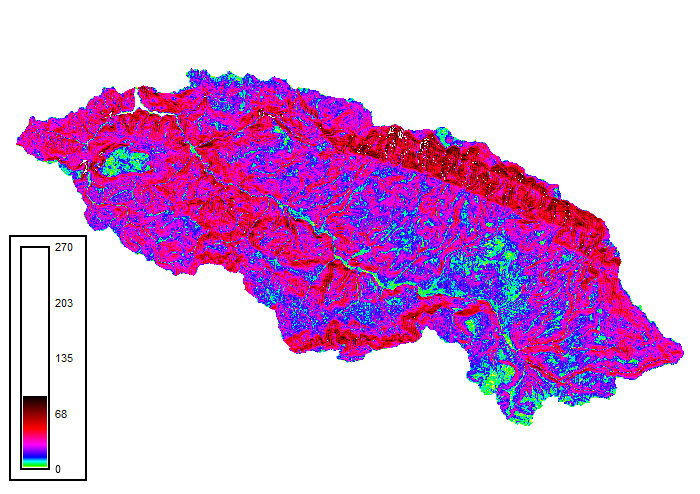

In [ ]:
gs.run_command("r.slope.aspect",
               elevation="Doganci_DEM",
               slope="slope",
               format="percent",
               overwrite=True)

slope_map = gj.Map(use_region=True, width=700)
slope_map.d_rast(map="slope")
slope_map.d_legend(raster="slope", at=(5,50,3,7), flags="b")
slope_map.show()

## Calculate the slope-area term using Maidment et al. equation

$$
V = V_m \times \frac{s^{b} A^{c}}{s^{b} A^{c}_m}
$$

where:  
- $\ V $ is the velocity of a single cell with a local slope $\ s $ and an upstream contributing area $\ A $.  
- Coefficients $\ b $ and $\ c $ can be determined by calibration, a statistical method of tweaking model parameters so that predicted data is as close as possible to observed data. In this scenario, you'll use the recommended values $\ b = c = 0.5 $.  
- $\ V_m $ is the average velocity of all cells in the watershed. Assume $\ V_m = 0.1 $ m/s.  
- $\ s^{b} A^{c}_m $ is the average slope-area term throughout the watershed.

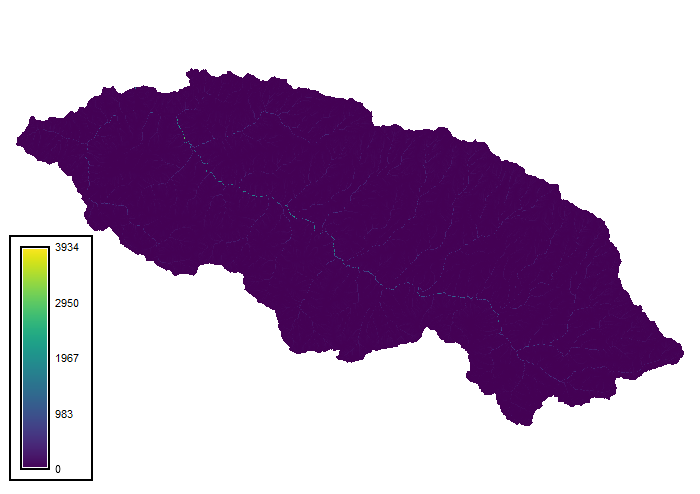

In [21]:
# Calculate the slope-area term (the value s^b A^c from the Maidment et al. equation)
slope = "slope"
flow_accumulation = "flowacc"
slope_area_expr = f"slope_area_term = sqrt({slope}) * sqrt({flow_accumulation})"

gs.run_command("r.mapcalc", expression=slope_area_expr)

slope_area_term_map = gj.Map(use_region=True, width=700)
slope_area_term_map.d_rast(map="slope_area_term")
slope_area_term_map.d_legend(raster="slope_area_term", at=(5,50,3,7), flags="b")
slope_area_term_map.show()

## Identify mean value for slope-area term to calculate the velocity field

In [ ]:
slope_area_term_univar = gs.parse_command("r.univar", map="slope_area_term", flags="g")
slope_area_term_mean = slope_area_term_univar["mean"]
print(f"Slope area term average is {slope_area_term_mean}")

Slope area term average is 21.2180134133541


## Calculate the velocity field

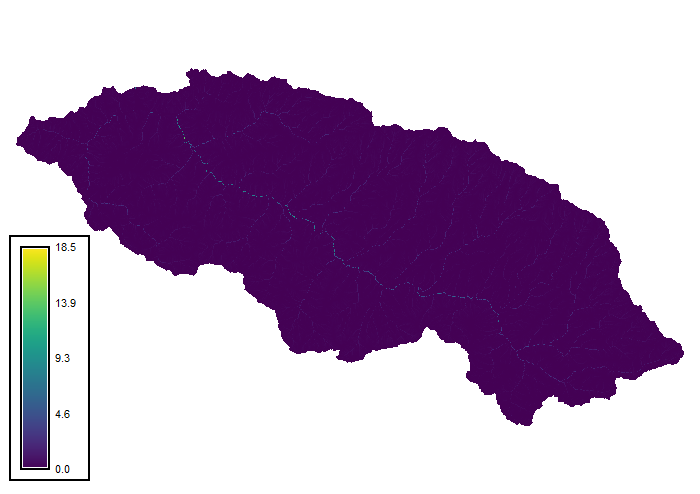

In [ ]:
slope_area_term = "slope_area_term"
velocity_unlimited_expr = f"velocity_unlimited = 0.1 * ({slope_area_term} / {slope_area_term_mean})"

gs.run_command("r.mapcalc", expression=velocity_unlimited_expr)

velocity_unlimited_map = gj.Map(use_region=True, width=700)
velocity_unlimited_map.d_rast(map="velocity_unlimited")
velocity_unlimited_map.d_legend(raster="velocity_unlimited", at=(5,50,3,7), flags="b")
velocity_unlimited_map.show()

## Limit the velocities

The velocity layer (before calibration) contains unrealistically high and low values. It includes a 0 m/s value, which is highly unlikely during an extreme rainfall event. The maximum value, 18.5 m/s, is also unrealistic — even during a major flood event. It is considered good practice to apply limits to the velocity layer. In this case, the lower limit is set to 0.02 m/s and the upper limit to 2 m/s, as shown in the velocity layer (after calibration).

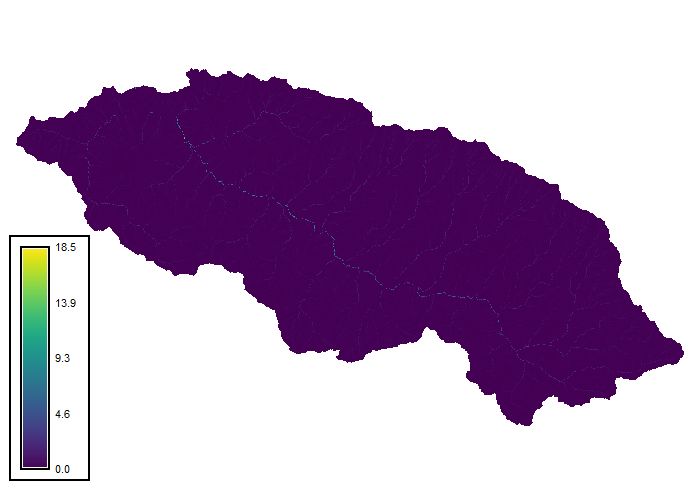

In [ ]:
velocity_unlimited = "velocity_unlimited"
velocity_lower_limited_expr = f"velocity_lower_limited = if ({velocity_unlimited} >= 0.02, {velocity_unlimited}, 0.02)"

gs.run_command("r.mapcalc", expression=velocity_lower_limited_expr)

velocity_lower_limited_map = gj.Map(use_region=True, width=700)
velocity_lower_limited_map.d_rast(map="velocity_lower_limited")
velocity_lower_limited_map.d_legend(raster="velocity_lower_limited", at=(5,50,3,7), flags="b")
velocity_lower_limited_map.show()


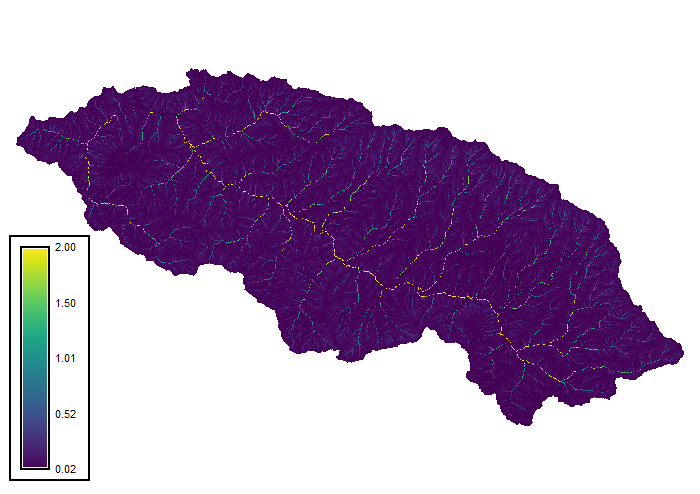

In [28]:
# Velocity calibration
velocity_lower_limited = "velocity_lower_limited"
velocity_expr = f"velocity = if ({velocity_lower_limited} <= 2, {velocity_lower_limited}, 2)"

gs.run_command("r.mapcalc", expression=velocity_expr)

velocity_map = gj.Map(use_region=True, width=700)
velocity_map.d_rast(map="velocity")
velocity_map.d_legend(raster="velocity", at=(5,50,3,7), flags="b")
velocity_map.show()

## Create a weight layer

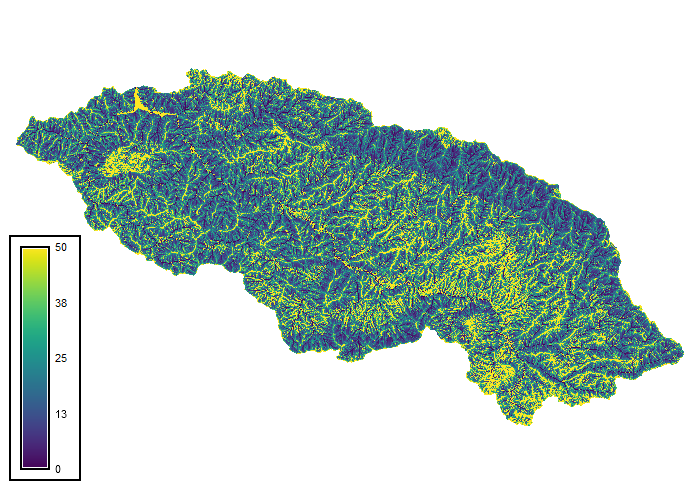

In [ ]:
velocity = "velocity"
weight_expr = f"weight = 1 / {velocity}"

gs.run_command("r.mapcalc", expression=weight_expr)

weight_map = gj.Map(use_region=True, width=700)
weight_map.d_rast(map="weight")
weight_map.d_legend(raster="weight", at=(5,50,3,7), flags="b")
weight_map.show()

## Create flow time layer to outlet pour point

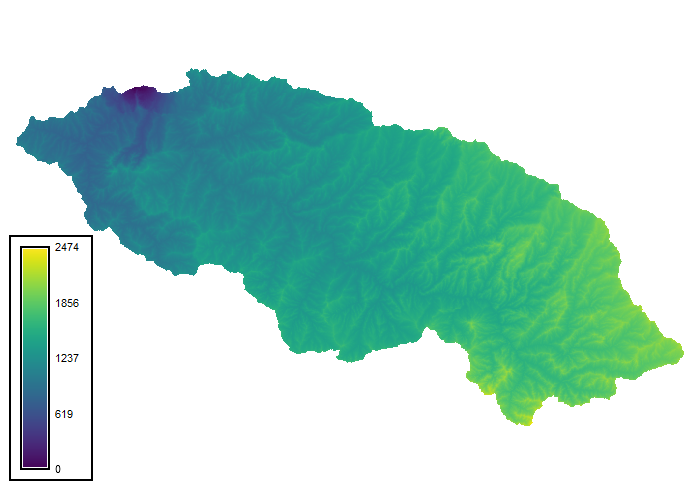

In [ ]:
gs.run_command("r.cost",
               input="weight",
               output="time",
               start_coordinates=[667231.7282054082,4442224.201007766],
               overwrite=True)

time_map = gj.Map(use_region=True, width=700)
time_map.d_rast(map="time")
time_map.d_legend(raster="time", at=(5,50,3,7), flags="b")
time_map.show()

Note that the generated time raster map is in seconds.

## Reclassify flow time into isochrone zones

In [ ]:
def generate_reclass_rules(min_val, max_val, interval, round_up=True):
    rules = []
    current = (int(min_val) // interval) * interval
    end = max_val if not round_up else ((int(max_val) + interval - 1) // interval) * interval
    class_id = 1

    while current < end:
        next_val = current + interval
        rule = f"{current}:{next_val}:{class_id}"
        rules.append(rule)
        current = next_val
        class_id += 1

    return rules

min_seconds = 0
max_seconds = 2474
interval_seconds = 60

rules = generate_reclass_rules(min_seconds, max_seconds, interval_seconds)

for rule in rules:
    print(rule)

0:60:1
60:120:2
120:180:3
180:240:4
240:300:5
300:360:6
360:420:7
420:480:8
480:540:9
540:600:10
600:660:11
660:720:12
720:780:13
780:840:14
840:900:15
900:960:16
960:1020:17
1020:1080:18
1080:1140:19
1140:1200:20
1200:1260:21
1260:1320:22
1320:1380:23
1380:1440:24
1440:1500:25
1500:1560:26
1560:1620:27
1620:1680:28
1680:1740:29
1740:1800:30
1800:1860:31
1860:1920:32
1920:1980:33
1980:2040:34
2040:2100:35
2100:2160:36
2160:2220:37
2220:2280:38
2280:2340:39
2340:2400:40
2400:2460:41
2460:2520:42


## Create an isochrone layer

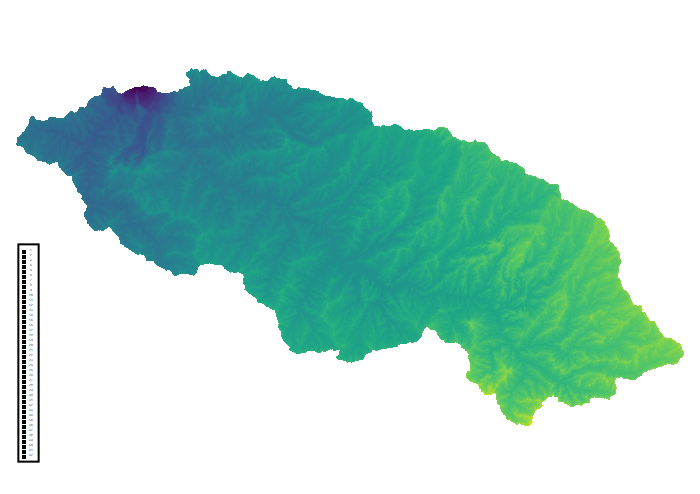

In [ ]:
import os

rules_file_path = "reclass_rules.txt"
with open(rules_file_path, "w") as f:
    for rule in rules:
        f.write(rule + "\n")

gs.run_command("r.recode",
               input="time",
               output="isochrones",
               rules=rules_file_path,
               overwrite=True)

os.remove(rules_file_path)

isochrones_map = gj.Map(use_region=True, width=700)
isochrones_map.d_rast(map="isochrones")
isochrones_map.d_legend(raster="isochrones", at=(5,50,3,7), flags="b")
isochrones_map.show()


## Prepare the unit hydrograph table

r.report was used to derive cell area in square meters and cell count, which were then used to create a unit hydrograph table.

In [ ]:
import pandas as pd
import re

report = gs.parse_command("r.report",
                          map="isochrones",
                          units=["meters", "cells", "percent"],
                          flags="na")

lines = list(report.keys())

pattern = re.compile(r"^\|\s*(\d+)\|.*?\|\s*([\d,]+)\|\s*([\d,]+)\|\s*([\d.]+)\|")

data = []

for line in lines:
    match = pattern.match(line)
    if match:
        cat = int(match.group(1))
        area = int(match.group(2).replace(",", ""))
        cells = int(match.group(3).replace(",", ""))
        percent = float(match.group(4))
        data.append((cat, area, cells))

df = pd.DataFrame(data, columns=["Category", "Area_m2", "Cell_Count"])
df["Time_S"] = df["Category"] * 60
df["UH_Ordinate"] = df["Area_m2"] * 60
df.head()

,Category,Area_m2,Cell_Count,Time_S,UH_Ordinate
0,1,52200,58,60,3132000
1,2,164700,183,120,9882000
2,3,224100,249,180,13446000
3,4,324900,361,240,19494000
4,5,390600,434,300,23436000


## Create a unit hydrograph

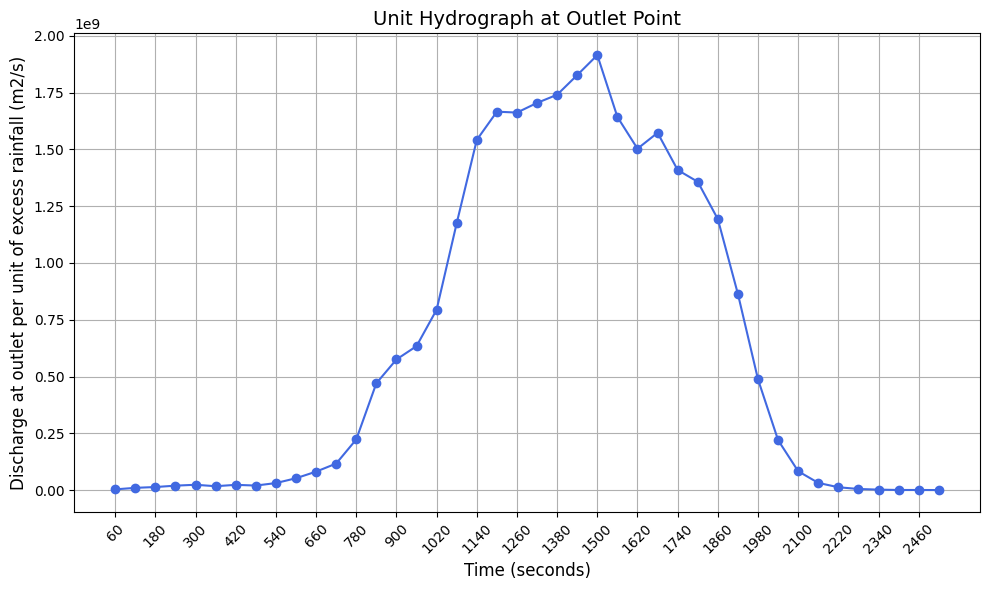

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df["Time_S"], df["UH_Ordinate"], marker="o", linestyle="-", color="royalblue")

plt.title("Unit Hydrograph at Outlet Point", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Discharge at outlet per unit of excess rainfall (m2/s)", fontsize=12)
plt.grid(True)
plt.xticks(df["Time_S"][::2], rotation=45)
plt.tight_layout()
plt.show()

The UH Ordinate value is obtained by multiplying the Area (in m2/s) by the time interval (the “Value” column), which is 60 seconds. Both the Area and UH Ordinate columns are then used to create the unit hydrograph as shown above.

But there is one thing to note. According to Sherman (1932), the unit hydrograph is “the hydrograph of surface runoff resulting from effective rainfall falling in a unit of time.” The effective rainfall refers to the portion of rainfall that contributes to the storm hydrograph. We can assume this to be the flow of water that does not infiltrate into the soil and instead flows over the surface. This process is also known as infiltration excess or Hortonian overland flow.

Surface runoff is often assumed to be uniformly distributed over the catchment and to occur with uniform timing. However, this assumption is not accurate. GIS can be used to model overland flow using geoprocessing tools or specialized modules for hydrological modeling. Still, it is important to remember that surface flow within a catchment is not uniform. This is because variations in soil type and land cover across the catchment significantly affect how surface runoff behaves.

If the unit hydrograph is created while taking latter factors into account, more accurate results can be obtained. However, it is important to keep in mind that this method remains an approximation of the real-world phenomenon. Therefore, the results should be used as estimates of how much water is likely to flow in the river during a rainfall event.

<p style="text-align: center;"><strong>Izza Prasatya Arief, 2025</strong></p>